# Hyper-parameter optimization analysis

In [1]:
import os
import sys
import glob
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 14.0

## Specify the results to load

In [4]:
ls /global/cscratch1/sd/sfarrell/heptrkx/results

RNNFilter_20180207_1121/  hpo_agnn_534171_3/   mpnn_hpo_526841_25/
agnn_000/                 hpo_agnn_534172_0/   mpnn_hpo_526841_26/
agnn_001/                 hpo_agnn_534172_1/   mpnn_hpo_526841_27/
agnn_002/                 hpo_agnn_534172_10/  mpnn_hpo_526841_28/
agnn_002_8gpu/            hpo_agnn_534172_11/  mpnn_hpo_526841_3/
agnn_003/                 hpo_agnn_534172_2/   mpnn_hpo_526841_4/
agnn_004/                 hpo_agnn_534172_3/   mpnn_hpo_526841_5/
agnn_005/                 hpo_agnn_534172_4/   mpnn_hpo_526841_6/
agnn_006/                 hpo_agnn_534172_5/   mpnn_hpo_526841_7/
agnn_007/                 hpo_agnn_534172_6/   mpnn_hpo_526841_8/
agnn_008/                 hpo_agnn_534172_7/   mpnn_hpo_526841_9/
agnn_009/                 hpo_agnn_534172_8/   mpnn_med_000/
agnn_010/                 hpo_agnn_534172_9/   mpnn_med_001/
agnn_big_000/             hpo_mpnn_534173_0/   mpnn_test/
agnn_big_001/             hpo_mpnn_534173_1/   nragnn_000/
agnn_big_002/             hpo_m

In [5]:
result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_*'))
result_dirs

In [7]:
configs = [load_config_dir(r) for r in result_dirs]
results = [load_summaries(c) for c in configs]

## Plot and compare

In [8]:
def make_summary(config, result):
    """Extracts summary information from one result for building a summary table"""
    best = result.valid_loss.idxmin()
    return dict(
        n_ranks=config['n_ranks'],
        batch_size=config['data']['batch_size'],
        real_weight=config['data']['real_weight'],
        model=config['model']['name'],
        n_edge_layers=config['model']['n_edge_layers'],
        n_node_layers=config['model']['n_node_layers'],
        hidden_dim=config['model']['hidden_dim'],
        n_graph_iters=config['model']['n_graph_iters'],
        lr=config['optimizer']['learning_rate'],
        weight_decay=config['optimizer']['weight_decay'],
        train_loss=result.train_loss[best],
        valid_loss=result.valid_loss[best],
        last_valid_loss=result.valid_loss.iloc[-1],
        last_epoch=result.epoch.max(),
        best_epoch=result.epoch[best],
    )

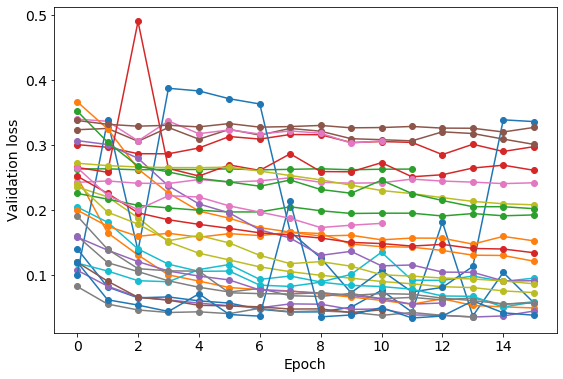

In [9]:
plt.figure(figsize=(9, 6))

for result in results:
    plt.plot(result.epoch, result.valid_loss, 'o-')

#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Validation loss');

In [14]:
# Make the summary table
summaries = pd.DataFrame([make_summary(c, r) for (c, r) in zip(configs, results)])
summaries.sort_values('last_valid_loss')

,n_ranks,batch_size,real_weight,model,n_edge_layers,n_node_layers,hidden_dim,n_graph_iters,lr,weight_decay,train_loss,valid_loss,last_valid_loss,last_epoch,best_epoch
7,8,1,3.727151,agnn,2,2,128,15,0.00100,0.000328,0.069510,0.034954,0.034954,13,13
20,8,1,1.590228,mpnn,4,1,256,7,0.00100,0.000754,0.055895,0.033259,0.037546,15,11
4,8,1,3.000000,agnn,4,4,32,8,0.00100,0.000100,0.064565,0.034693,0.043916,15,13
15,8,1,5.733022,agnn,4,2,256,6,0.00010,0.000175,0.087818,0.041677,0.045809,10,9
1,8,1,2.883365,agnn,2,8,64,8,0.00010,0.000586,0.083152,0.048717,0.048717,15,15
27,8,1,3.000000,mpnn,4,4,32,8,0.00100,0.000100,0.095512,0.054935,0.056284,15,14
24,8,1,2.095027,mpnn,8,2,128,15,0.00010,0.000842,0.084974,0.054557,0.056378,12,11
0,8,1,3.000000,agnn,4,4,32,8,0.00100,0.000100,0.066020,0.036443,0.056855,15,13
19,8,1,5.452273,mpnn,1,2,64,11,0.00100,0.000201,0.111997,0.049964,0.057980,15,14
17,8,1,3.000000,mpnn,4,4,32,8,0.00100,0.000100,0.100133,0.053988,0.058018,15,14


## View the best performing models

In [15]:
best = summaries.last_valid_loss.idxmin()
best_config = configs[best]
best_result = results[best]

best_result

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.277483,2749.336257,17.268267,0,266.426883,0.081785,0.968842,8.113882
1,0.001,0.112934,2558.645384,16.190055,1,265.465542,0.054733,0.981422,8.878791
2,0.001,0.093151,2215.134771,15.056794,2,265.102494,0.045611,0.985396,8.281799
3,0.001,0.088799,1961.593062,14.307090,3,265.470297,0.041721,0.986830,9.740657
4,0.001,0.091996,1803.866134,13.886063,4,265.397593,0.042764,0.986546,8.040379
5,0.001,0.085977,1662.359219,13.494791,5,396.342770,0.039918,0.987306,8.863168
6,0.001,0.086825,1942.142656,13.803576,6,265.689214,0.048155,0.984196,7.934803
7,0.001,0.076532,1500.734924,13.057968,7,265.219162,0.042853,0.986430,8.431493
8,0.001,0.072435,1357.380215,12.561783,8,266.243325,0.044139,0.986330,8.121357
9,0.001,0.081130,1388.175920,12.662674,9,265.448469,0.042031,0.986736,8.087638


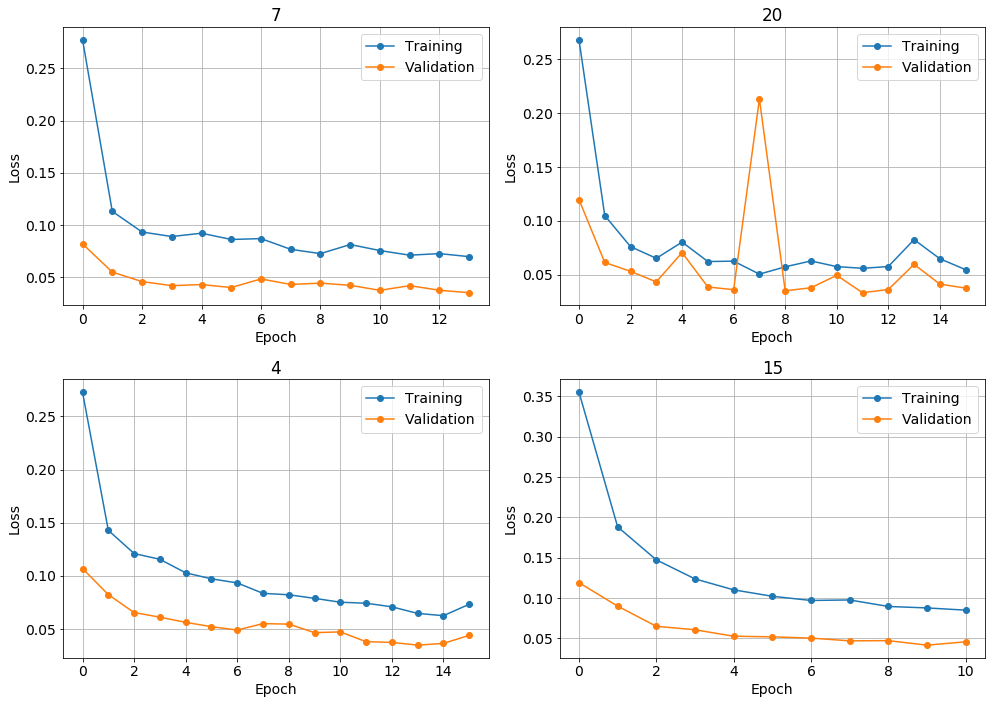

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

for i, ax in zip(summaries.sort_values('last_valid_loss').index, axs.flatten()):
    
    result = results[i]
    ax.set_title(i)
    
    ax.plot(result.epoch, result.train_loss, 'o-', label='Training')
    ax.plot(result.epoch, result.valid_loss, 'o-', label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc=0)
    ax.grid()

plt.tight_layout()

## Runtime statistics

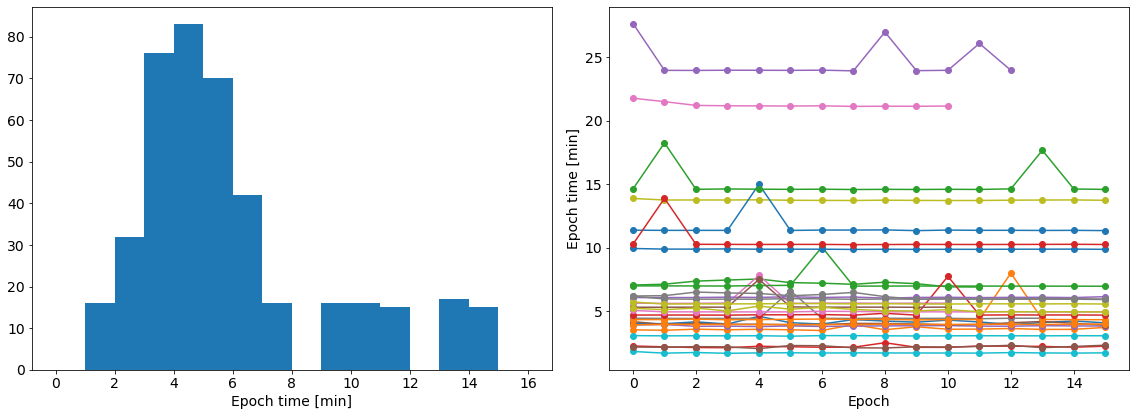

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))

# Histogram of all epoch times
all_epoch_times = pd.concat([r.train_time/60 for r in results], ignore_index=True)
ax0.hist(all_epoch_times, bins=16, range=(0, 16))
ax0.set_xlabel('Epoch time [min]')

# Epoch time vs epoch for each result
for r in results:
    ax1.plot(r.epoch, r.train_time/60, 'o-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Epoch time [min]')

plt.tight_layout()